In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import os
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

# Mount Google Drive to access your files
drive.mount('/content/drive') #, force_remount=True if need to remount

# !ls /content/drive/MyDrive/
# !ls /content/drive/MyDrive/Project-4/NormalBrainMRI_Images_files/Normal/
# !ls /content/drive/MyDrive/Project-4/Tumors/Tumor/

# Initialize the ImageDataGenerator with rescaling and validation split
# datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

tumor_dir = '/content/drive/MyDrive/Project-4/Tumors/Tumor/'
normal_dir = '/content/drive/MyDrive/Project-4/NormalBrainMRI_Images_files/Normal/'




'''
Why I chose tf.keras.utils.image_dataset_from_directory() instead of chose datagen.flow_from_directory():

Modern API: It's the more modern approach and is better integrated with TensorFlow 2.x's eager execution and @tf.function optimizations.
Performance: The tf.data API can potentially offer better performance, especially for large datasets, due to its ability to optimize the input pipeline.
Flexibility: It's easier to apply transformations and optimizations to the dataset using the tf.data API methods.
Simplicity: For your use case, where we're not doing complex data augmentation, this method provides a simpler, more straightforward approach.
Future-proofing: As TensorFlow continues to evolve, the tf.data API is likely to see more improvements and optimizations.
Consistent with modern TensorFlow practices: If you continue to work with TensorFlow, using this method aligns with current best practices and makes it easier to learn and apply more advanced techniques.
'''



Mounted at /content/drive


"\nWhy I chose tf.keras.utils.image_dataset_from_directory() instead of chose datagen.flow_from_directory():\n\nModern API: It's the more modern approach and is better integrated with TensorFlow 2.x's eager execution and @tf.function optimizations.\nPerformance: The tf.data API can potentially offer better performance, especially for large datasets, due to its ability to optimize the input pipeline.\nFlexibility: It's easier to apply transformations and optimizations to the dataset using the tf.data API methods.\nSimplicity: For your use case, where we're not doing complex data augmentation, this method provides a simpler, more straightforward approach.\nFuture-proofing: As TensorFlow continues to evolve, the tf.data API is likely to see more improvements and optimizations.\nConsistent with modern TensorFlow practices: If you continue to work with TensorFlow, using this method aligns with current best practices and makes it easier to learn and apply more advanced techniques.\n"

In [ ]:
# Set up parameters for image loading
img_height = 224  # Adjust based on your needs
img_width = 224   # Adjust based on your needs
batch_size = 32   # Number of images to process in each batch

def create_dataset(directory, label, validation_split=0.2, subset='training'):
    return tf.keras.utils.image_dataset_from_directory(
        directory,
        labels=[label] * len(os.listdir(directory)),  # Manually specify labels
        label_mode='int',
        validation_split=validation_split,  # Use 20% of data for validation
        subset=subset,                      # This creates the training dataset
        seed=123,                           # Set a seed for reproducibility
        image_size=(img_height, img_width), # Resize all images to this size
        batch_size=batch_size,              # Number of images per batch
        shuffle=True                        # Shuffle the data: 1. Preventing order bias, 2.Improving generalization, 3. Reducing overfitting, 4. Balancing class distribution, 5. Stochastic gradient descent
                                            # Will provide further explanation in read me
        )

In [ ]:
# Create training datasets
tumor_train = create_dataset(tumor_dir, label=1, subset='training')
normal_train = create_dataset(normal_dir, label=0, subset='training')

Found 184 files belonging to 1 classes.
Using 148 files for training.
Found 136 files belonging to 1 classes.
Using 109 files for training.


In [ ]:
# Create validation datasets
tumor_val = create_dataset(tumor_dir, label=1, subset='validation')
normal_val = create_dataset(normal_dir, label=0, subset='validation')

Found 184 files belonging to 1 classes.
Using 36 files for validation.
Found 136 files belonging to 1 classes.
Using 27 files for validation.


In [ ]:
# Combine datasets
train_ds = tumor_train.concatenate(normal_train)
val_ds = tumor_val.concatenate(normal_val)

In [ ]:
# Optimize the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #This shuffle isn't redundant; it provides an extra layer of randomization.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

for image_batch, labels_batch in train_ds.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Labels batch shape:", labels_batch.shape)

Image batch shape: (32, 224, 224, 3)
Labels batch shape: (32,)


In [ ]:
# Print information about the dataset
print("Number of training batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Number of validation batches:", tf.data.experimental.cardinality(val_ds).numpy())

for image_batch, labels_batch in train_ds.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Labels batch shape:", labels_batch.shape)

Number of training batches: 9
Number of validation batches: 3
Image batch shape: (20, 224, 224, 3)
Labels batch shape: (20,)


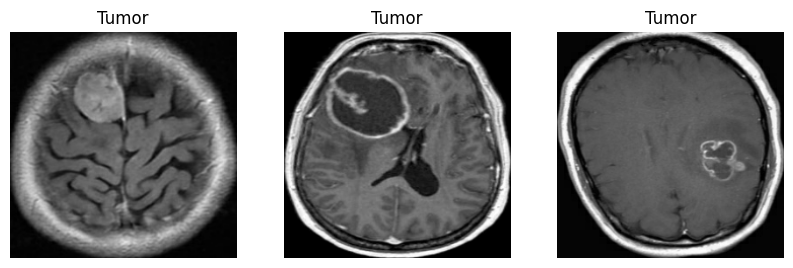

In [ ]:
# Visualize some images from the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Tumor' if labels[i] == 1 else 'Normal')
        plt.axis("off")

plt.show()

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define the CNN model
def create_cnn_model(input_shape=(224, 224, 3)):
    model = models.Sequential([
        # First convolutional layer
        # 32 filters, 3x3 kernel size, ReLU activation
        # Input shape is (224, 224, 3) for RGB images
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        # Max pooling layer to reduce spatial dimensions
        layers.MaxPooling2D((2, 2)),

        # Second convolutional layer
        # 64 filters, 3x3 kernel size, ReLU activation
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Third convolutional layer
        layers.Conv2D(64, (3, 3), activation='relu'),

        # Flatten the 2D feature maps for the fully connected layers
        layers.Flatten(),

        # Fully connected layer with 64 units and ReLU activation
        layers.Dense(64, activation='relu'),

        # Output layer with sigmoid activation for binary classification
        # Outputs a probability between 0 and 1
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
# Create and compile the model
model = create_cnn_model()
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    loss='binary_crossentropy',  # Appropriate loss function for binary classification
    metrics=['accuracy']  # We want to track accuracy during training
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=10  # Number of times to iterate over the entire dataset
)

# Visualize training history
plt.figure(figsize=(12, 4))

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4006 - loss: 1050.0615 - val_accuracy: 0.5714 - val_loss: 0.6896
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7373 - loss: 0.5966 - val_accuracy: 0.6032 - val_loss: 0.6630
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7149 - loss: 0.6069 - val_accuracy: 0.6508 - val_loss: 0.6517
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7212 - loss: 1.3789 - val_accuracy: 0.5714 - val_loss: 0.7722
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7560 - loss: 0.4656 - val_accuracy: 0.6825 - val_loss: 0.6027
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8140 - loss: 0.4360 - val_accuracy: 0.6349 - val_loss: 1.2334
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5977 - loss: 0.9772 - val_accuracy: 0.6508 - val_loss: 0.6027
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8322 - loss: 3.8222 - val_accuracy: 0.6032 - val_loss: 0.673

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

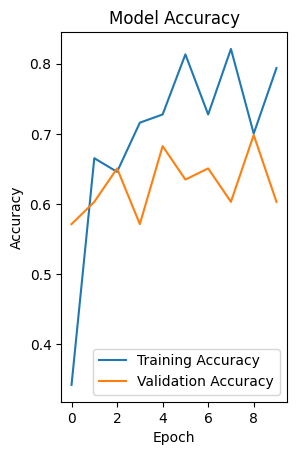

In [ ]:
# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

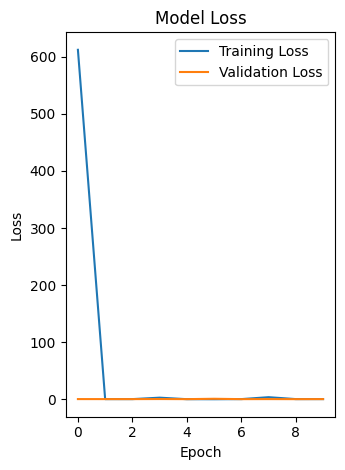

In [ ]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation accuracy: {val_accuracy:.4f}")

# Note: If the validation accuracy is below 75%, you may need to:
# 1. Train for more epochs
# 2. Adjust the model architecture (e.g., add more layers or change layer sizes)
# 3. Use data augmentation to increase dataset diversity
# 4. Try different learning rates or optimizers
# 5. Ensure your dataset is balanced between tumor and non-tumor images

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5663 - loss: 0.6940
Validation accuracy: 0.6032


Since we only got 65% accuracy I will attempt Data Augmentation since its such a small dataset. This can increase our dataset size and help prevent overfitting.

I wwill use Transfer Learning; a VGG16 model since its trained on large datasets and can be fine-tuned for this task.

We will implement early stopping to prevent overfitting.

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Data Augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

# Apply augmentation to the training dataset
train_ds_augmented = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# Optimize for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds_augmented = train_ds_augmented.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)




In [ ]:
# Load the pre-trained VGG16 model to use transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create the final model
model = models.Sequential([
    # Add custom layers
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Implement k-fold cross-validation
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores = []

# for fold, (train_indices, val_indices) in enumerate(kfold.split(train_ds)):
#     print(f"Fold {fold+1}")

#     # Create train and validation sets for this fold
#     train_fold = train_ds.take(train_indices.size)
#     val_fold = train_ds.skip(train_indices.size).take(val_indices.size)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train the model
history = model.fit(
    train_ds_augmented,
    validation_data=val_ds,
    epochs=70,
    callbacks=[early_stopping]
)

Epoch 1/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.2840 - loss: 9.8937 - val_accuracy: 0.6032 - val_loss: 4.6529
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - accuracy: 0.5219 - loss: 5.9928 - val_accuracy: 0.6190 - val_loss: 4.4181
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.4930 - loss: 5.7581 - val_accuracy: 0.6349 - val_loss: 4.1280
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.6195 - loss: 5.0848 - val_accuracy: 0.6508 - val_loss: 4.0698
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.5662 - loss: 5.4866 - val_accuracy: 0.7460 - val_loss: 3.9318
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.5340 - loss: 5.8208 - val_accuracy: 0.7302 - val_loss: 3.8809
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.6216 - loss: 4.9499 - val_accuracy: 0.7460 - val_loss: 3.8575
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.5881 - loss: 5.1440 - val_accuracy: 0.7302 - val_loss: 

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation accuracy: {val_accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9921 - loss: 2.3112
Validation accuracy: 0.9841


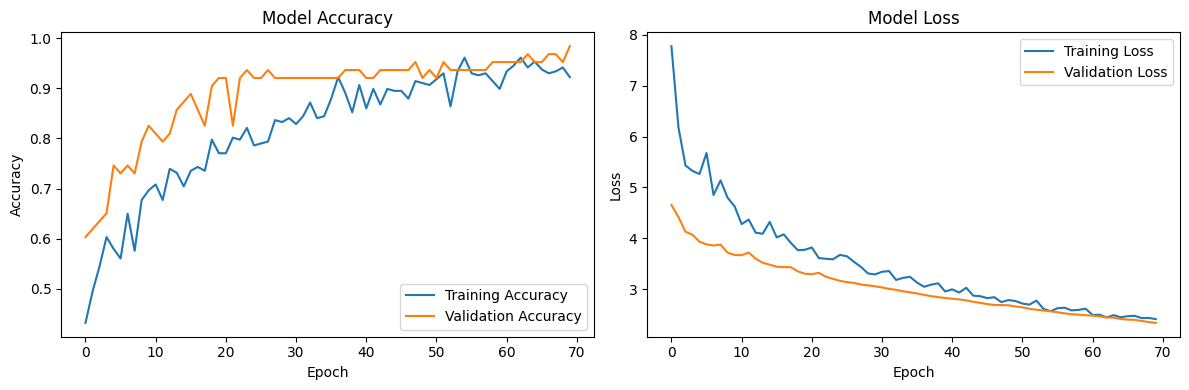

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation accuracy: {val_accuracy:.4f}")
print(f"Validation loss: {val_loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9921 - loss: 2.3112
Validation accuracy: 0.9841
Validation loss: 2.3369


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 775ms/step
Sample of prediction probabilities: [[0.99996805]
 [0.9997348 ]
 [0.9992168 ]
 [0.999401  ]
 [0.99999976]
 [0.5688907 ]
 [0.9999802 ]
 [0.9999995 ]
 [0.9991937 ]
 [0.99953246]]


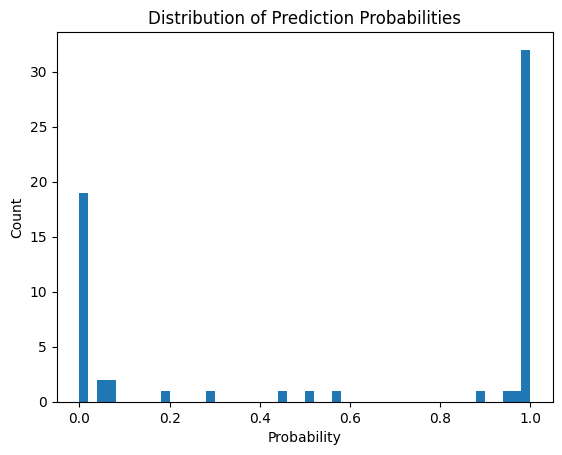

In [ ]:
# Examine prediction probabilities
predictions = model.predict(val_ds)
print("Sample of prediction probabilities:", predictions[:10])

# Plot prediction distribution
plt.hist(predictions, bins=50)
plt.title("Distribution of Prediction Probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()